<img src="https://www.climatechangewriters.com/images/2023/03/27/CCW9893490890_large.jpg" style="width:50%; display: block; margin-left: auto; margin-right: auto">
<table style="width:50%">
    <tr>
        <th>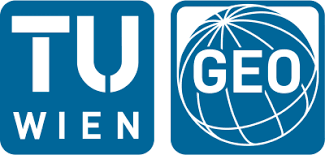</th>
        <th><img src="https://eodc.eu/wp-content/uploads/2018/10/EODC-Logo-Final.png"></th>
    </tr>
</table>

# DestinE Data Lake

The Destination Earth Data Lake (DEDL) combines such disparate data sources in one large virtual database. Moreover, this virtual database comes with a set of tools that facilitates the search for relevant resources as well as the analysis of data by performing computationally expensive operations near to the data source.

This Jupyter Notebook serves as an example of how the DEDL service can help design water management plans to prepare Italian socio-economic systems for prolonged periods of droughts. These conditions will become more prevalent under globally increasing temperatures.

## Infrastructure setup
<img src="./DEDL-Drought-UC2a-setup.jpg" style="width:75%; display: block; margin-left: auto; margin-right: auto">

### Create Dask Clusters on Central Site and Bridge
Make use of DEDL client library to create Dask cluster on each site registered in the DEDL.
Default settings are:
- Docker image used for Dask scheduler and workers
- worker CPU and memory
- enabled autoscaling

# Use Case 2a: Italy Drought 2022 - MetOp ASCAT

After an unusually dry winter, a water management expert is consulted to assess the impact to communal and agricultural water supplies in italy at the end of March 2022.

In case of prolonged absence of rain the expert would require information to prepare a national drought plan. This information should encompass current and future drought intensity as well as a measure of the impact of drought on critical sectors, such as agriculture, industry, and public water. The drought impact per sector is required to estabelish sector-specific mitigating measures that depend on a range of scenarios ranging from ameliorating conditions to severe drought predicted in the forseeable future.

In [ ]:
from dedl.services.stack import DaskCluster
from dask_gateway import Gateway

mycluster = DaskCluster(name="DEDLdemo")
user_auth = mycluster.login(username="christoph")
mycluster.create_cluster(authobj=user_auth)
mycluster.get_cluster_url()

## Access Data from DEDL Service

Using the DEDL package, data can be accessed from various services. In this example, data is retrieved from the European Organisation for the Exploitation of Meteorological Satellites (EUMETSAT) Data Store, the Copernicus Land Monitoring service (CLMS), and the European Centre for Medium-Range Weather Forecasts (ECMWF).

- The EUMETSAT Data Store enables access to **soil moisture data** as part of the Operational **Hydrology and water management (HSAF)** unit. The data consists of microwave images obtained by the the Advanced Scatterometer (ASCAT) satallite. Microwave imaging is a technique that is relatively unaffected by cloud cover and is especially sensitive to variations in near surface water content ($0 {-} 2\,\text{cm}$). This dataset is used to evaluate drought severeness at the beginning of March 2022.
- The CLMS is queried for the **CORINE ('Coordination of information on the environment') Land Cover inventory**. The original purpose of this data set serves environmental policy development and consists of 44 classes of land cover in five main units (artificial, agriculture, forests and semi-natural, wetlands, and water). It combines a number of sources, among which Landsat-5, Landsat-7, and ESA Sentinal-2 satallite imaging data in the most recent years. This dataset will highlight which sectors will be most likely drought impacted under the predicted scenario. 
- The ECMWF catalogue is used to obtain the multi-decadal **ERA5-Land dataset**. This product is a reanalysis dataset that gives insight in the seasonal variation of land variables by averaging data over multiple decades with a 9km spatial resolution. The ERA5-Land data is retrieved to estimate the development of drought over the months following the 30<sup>th</sup> of March 2022. This dataset is for demonstration purposes only, and will be replaced with a high resolution soil moisture prediction dataset in the future.

In [ ]:
import dask
import xarray as xr
from dedl.services import discovery
from usecase.parameters import Extent
from datetime import datetime

start_drought = datetime(2022, 3, 1)
end_drought = datetime(2022, 8, 31)

xr.set_options(keep_attrs=True)
drought_roi = Extent(6.15, 46.90, 19.60, 35.64, crs='EPSG:4326')    # Italy BBOX

### Login to DEDL storage service at central site and bridge

In [ ]:
central_site_da = discovery.S3DataAccess("https://s3.dedl-centralsite.eodc.eu")

In [ ]:
bridge_site_da = discovery.S3DataAccess("https://s3.dedl-bridge.eodc.eu")

### ASCAT Soil Moisture

In [ ]:
sm_sat_italy_summer_22 = discovery.find_ascat_sm(startdate=start_drought, enddate=end_drought, extent=drought_roi, S3Access=central_site_da)
sm_sat_italy_summer_22

### Predicated Soil Moisture

In [ ]:
sm_mdl_22 = discovery.find_predicted_sm(startdate=start_drought, enddate=end_drought, extent=drought_roi, S3Access=bridge_site_da)
sm_mdl_22

### Corine LandCover

In [ ]:
corine_italy = discovery.find_corine_LC(extent=drought_roi, S3Access=central_site_da)
corine_italy

## Preprocess the Data

The raw data requires preprocessing to be able to extract relevant information. 

This task is, however, computationally demanding and requires specialized IT infrastructure. The DEDL services are designed to cope with these computational limitations at the user's side by implementing distributed computation capabilities. This feature runs the task near to the source of the data. The user can therefore execute the script as if they would have performed it on their own local device (laptop, pc, or tablet). However, in reality, the computationally demanding tasks are executed at the high-performance computing facilities of DEDL. The DEDL services lower these barriers by performing these processing step close at the source of the data. Besides delegating computational intense processes to dedicated high performance clusters, this prevents redundant data transfer that cause further slowdown of the workflow. Combined, this toolchain provides an optimal user experience uninhibited by the user's hardware.

In [ ]:
from rasterio.enums import Resampling


def normalize(da: xr.DataArray) -> xr.DataArray:
        da_min = da.min()
        return (da - da_min) / (da.max() - da_min)

def clip_dataset_to_shape_file(ds, clip_shape_file):
    import geopandas as gpd
    clip_shape = gpd.read_file(clip_shape_file)
    ds = ds.rio.clip(clip_shape.geometry.apply(mapping), clip_shape.crs, drop=False, invert=False)
    return ds

#### load 4D MED catchment from user workspace for clipping

In [ ]:
import s3fs
import fsspec
import geopandas as gpd

s3_user = s3fs.S3FileSystem(anon=False,
                            key=central_site_da.key,
                            secret=central_site_da.secret,
                            use_ssl=True,
                            client_kwargs={"endpoint_url": central_site_da.location_url})

catchment_file = s3_user.open("dedl-user/4dmed_catchment/catch_med.geojson", 'rb')

catchment_df = gpd.read_file(catchment_file)
catchment_df

#### ASCAT (local execution)

In [ ]:
def preprocess_ascat_sm(sm: xr.DataArray, shpfile) -> xr.DataArray:
    import numpy as np
    from pyresample import geometry, kd_tree
    from affine import Affine

    def clip_dataset_to_extent(ds, geodf):
        roi_extent = geodf.total_bounds
        mask_lon = (ds.x >= roi_extent[0]) & (ds.x <= roi_extent[2])
        mask_lat = (ds.y >= roi_extent[1]) & (ds.y <= roi_extent[3])
        return ds.where(mask_lon & mask_lat, drop=True)
    
    sm.rio.write_nodata(np.nan, inplace=True)
    sm_mm = sm.resample(time='10D').mean('time')
    e7proj = "+proj=aeqd +lat_0=53 +lon_0=24 +x_0=5837287.81977 +y_0=2121415.69617 +datum=WGS84 +units=m +no_defs"
    geo_trans = [4200000, 200000, 5500000, 1500000]
    area_def = geometry.AreaDefinition("e7", "", "", e7proj,
                                       200, 200, geo_trans)
    swath_def = geometry.SwathDefinition(lons=sm_mm.lon.values, lats=sm_mm.lat.values)
    sm_area = xr.DataArray(np.full((200, 200, sm_mm.sizes['time']), np.nan, np.float32), {
        'time': sm_mm.time.values,
        'y': np.arange(1500000, 200000, -6500),
        'x': np.arange(4200000, 5500000, 6500)
    }, ['y', 'x', 'time'])
    sm_area.values = kd_tree.resample_nearest(swath_def, sm_mm.values, area_def,
                                              radius_of_influence=5000, fill_value=np.nan)
    sm_area = sm_area.transpose('time', 'y', 'x')
    sm_area = normalize(sm_area)
    sm_area.rio.write_crs(e7proj, inplace=True)
    sm_area.rio.write_transform(Affine.from_gdal(4200000, -6500, 0, 1500000, 0, 6500), inplace=True)
    sm_area.rio.write_nodata(np.nan, inplace=True)
    sm_area = sm_area.rio.reproject('EPSG:3857', resampling=Resampling.bilinear)
    #sm_area = clip_dataset_to_extent(sm_area, shpfile)
    return sm_area.rio.clip_box(7, 37, 18, 46.5, crs='EPSG:4326')


In [ ]:
sm_sat_ = preprocess_ascat_sm(sm_sat_italy_summer_22, catchment_df)
sm_sat_

#### ERA-5 predicated Soil Moisture

In [ ]:
def clip_dataset_to_extent(ds, geodf):
    roi_extent = geodf.total_bounds
    mask_lon = (ds.longitude >= roi_extent[0]) & (ds.longitude <= roi_extent[2])
    mask_lat = (ds.latitude >= roi_extent[1]) & (ds.latitude <= roi_extent[3])
    return ds.where(mask_lon & mask_lat, drop=True)

sm_mdl_italy_summer_22 = clip_dataset_to_extent(sm_mdl_22, catchment_df)
sm_mdl_mm = normalize(sm_mdl_italy_summer_22.resample(time='15D').mean('time'))
sm_mdl_mm

### run remote processing

In [ ]:
sm_mdl_mm_ = mycluster.client[sm_mdl_mm.attrs["location"]].compute(sm_mdl_mm, sync=True)
sm_mdl_mm_

#### Corine Land Cover

In [ ]:
def preprocess_corine(lc: xr.DataArray) -> xr.DataArray:
    steps = 500 // 100
    downsampled = lc.coarsen({'latitude': steps, 'longitude': steps}, boundary='trim').median()
    return downsampled.transpose('lc', 'latitude', 'longitude')


In [ ]:
lc = preprocess_corine(corine_italy)
lc

### run remote processing

In [ ]:
lc_ = mycluster.client[lc.attrs["location"]].compute(lc, sync=True)
lc_

## Inspect Data

The DEDL service provides functionality to quickly visualize the previously processed data. These features not only help to validate the queried data, and the applied data transformations, but also allows an assessment of the current situation of soil moisture with only minimal effort.  More so, it marks the starting point of exploratory data analysis signified by the formulation of hypotheses that can be quickly tested. With the available Sentinel-1 soil moisture data, the expert can easily spot that water stocks are already severely reduced in some regions, such as the Po Valley (Emilia-Romagna and Veneto) at the end of March 2022. More so, the CORINA land cover data suggests that reduced water tables are especially prevalent in areas with an extensive agricultural component. This raises the question how agricultural yield will fair if drought conditions prevail over the coming months.


In [ ]:
from pathlib import Path
from bokeh.models import FuncTickFormatter, FixedTicker, WheelZoomTool
from holoviews import Image, DynamicMap, extension
from matplotlib.colors import LinearSegmentedColormap
extension('bokeh')

wheel_zoom = WheelZoomTool(zoom_on_axis=False)
zoom = dict(default_tools=["pan", wheel_zoom])


In [ ]:
def load_cmap(file: Path) -> LinearSegmentedColormap:
    def to_hex_str(c_str: str) -> str:
        r_s, g_s, b_s = c_str.split()
        return f"#{int(r_s):02x}{int(g_s):02x}{int(b_s):02x}"

    ct_lines = file.read().splitlines()
    brn_yl_bu_colors = [to_hex_str(clr_str) for clr_str in ct_lines[:200]]
    return LinearSegmentedColormap.from_list("", brn_yl_bu_colors)


def render_ascat_sm_date(sm_da: xr.DataArray, date, **kwargs) -> Image:
    import pandas as pd
    with s3_user.open("s3://dedl-user/colour-tables/ssm-continuous.ct", 'rb') as f:
        sm_ct = load_cmap(f)
    color_opts = dict(
        cmap=sm_ct,
        clipping_colors={'NaN': 'rgba(0, 0, 0, 0)', 'min': 'rgba(0, 0, 0, 0)'},
        colorbar=True
    )
    r = sm_da.sel({'time': date}, method='nearest').rename('SM')
    return Image(r).redim.range(SM=(0, 1)).opts(**color_opts, **kwargs, xlabel="longitude", ylabel="latitude")

def render_corine(lc_da: xr.DataArray, **kwargs):
    import numpy as np
    levels = list(range(1, 6))
    colors = ["#e6004d", "#ffff00", "#4dff00", "#a6a6ff", "#80f2e6"]

    # only major classes
    lc_da_copy = lc_da.copy()
    lc_da_copy.corine_lc.data = np.floor(lc_da_copy.corine_lc.data / 100)

    formatter = FuncTickFormatter(code='''
        return {1.0 : 'Artificial surfaces', 2.0 : 'Agricultural areas', 3.0 : 'Forest and seminatural areas', 4.0 : 'Wetlands', 5.0 : 'Water bodies'}    
        [tick]'''
                                  )
    ticker = FixedTicker(ticks=levels)

    color_opts = dict(
        cmap=colors,
        colorbar=True,
        clipping_colors={'NaN': 'rgba(0, 0, 0, 0)'},
        colorbar_opts={'ticker': ticker, 'formatter': formatter}
    )
    return Image(lc_da_copy['corine_lc'][0]).opts(**color_opts, **kwargs, **zoom, xlabel="longitude", ylabel="latitude")
 


### reproject data

In [ ]:
lc_reprojected = lc_.rio.write_crs('EPSG:4326').rio.reproject('EPSG:3857')

In [ ]:
sm_view = render_ascat_sm_date(sm_sat_, sm_sat_.time.values[0], width=600, height=500, title="A) Measured current state of soil moisture from ASCAT")
lc_view = render_corine(lc_reprojected, width=565, height=500, title="B) Land cover (CORINE 2018)")
sm_view + lc_view

*Fig 1 A) Current state (March 2022) of soil moisture based on ASCAT backscatter imaging B) CORINE Land Cover 2018.*

## Predicting Drought

The DEDL services provide also generic modelling components to enable an user-specific predictive assessment of future conditions. In this regard the water management expert is interested in the soil moisture content over the months starting at April and ending in August. 

In [ ]:
with s3_user.open("s3://dedl-user/colour-tables/ssm-continuous.ct", 'rb') as f:
        sm_ct = load_cmap(f)
color_opts = dict(
        cmap=sm_ct,
        clipping_colors={'NaN': 'rgba(0, 0, 0, 0)', 'min': 'rgba(0, 0, 0, 0)'},
        colorbar=True
    )

def render_era5l_swvl(sm_da: xr.DataArray, **kwargs) -> pn.Column:
    import pandas as pd

    class ERA5LSwvl1Explorer(pm.Parameterized):
        month = pm.Selector([pd.to_datetime(t).date() for t in sm_da.time.values])

        @pm.depends('month')
        def sm(self):
            r = sm_da.sel({'time': self.month}, method='nearest').rename('SM')
            return Image(r).redim.range(SM=(0, 1)).opts(**color_opts, **kwargs, **zoom, xlabel="longitude", ylabel="latitude")

        def map(self):
            return DynamicMap(self.sm)

    explorer = ERA5LSwvl1Explorer(name='')
    time_slider = pn.widgets.DiscreteSlider.from_param(explorer.param.month, width=kwargs.get('width', 512))
    return pn.Column(explorer.map(), time_slider)

def render_era5l_swvl_grid(sm_da: xr.DataArray, date) -> Image:
    r = sm_da.sel({'time': date}, method='nearest').rename('SM')
    return Image(r).redim.range(SM=(0, 1)).opts(**color_opts, xlabel="longitude", ylabel="latitude",  width=600, height=500)

### Reproject data

In [ ]:
sm_mdl_mm_reprojected = sm_mdl_mm_.rio.reproject('EPSG:3857')

In [ ]:
from holoviews import NdLayout
months = sm_mdl_mm_reprojected.time.values
image_container = {(m):render_era5l_swvl_grid(sm_mdl_mm_reprojected, m) for m in months}
NdLayout = NdLayout(image_container, kdims=['Date'])
NdLayout.cols(2)

*Fig 2 A) Predicted soil moisture for the months March upt August 2022 B) CORINE Land Cover 2018.*

The model results (Fig 2) indicate that intensified drought can be expected for the six months following the beginning of this survey. Moreover the simulated results suggest that especially agricultural areas will be inflicted by drought.

The water management expert uses this scenario to preemptively call on water preserving measures and estabelish rationing plans whilst identifying the most critical systems. Preserving measures can consist of changing to crops that are more well adapted to prolonged drought, which include drought adapted varieties of corn, wheat, and rice and already drough-tolerant soy. Alternatively, a reduction of hydro-electrical energy production could reduce consumption of water. Whereas proactive rationing can reduce the overall pressure on harvests by more effective spreading of water consumption restrictions over longer periods, which reduces the risk of total crop failure.

The effectiveness of this survey relies on combining multiple data sources with high-performance computing, which are the core competencies of the DEDL services.

## Retrospective Analysis of the DEDL Services 

The Italy drought event of 2022 severely affected water supply in the regions Emilia-Romagna and Veneto along the river Po. These regions are known for their high agricultural yields and a significant proportion of the European crop production takes place here. Estimates suggest that ~6 billion euro of produce were damaged during this particular drought event. Besides dwindling water supplies, low ground water levels caused saltwater intrusion into fresh water aquifers in some of the coastal regions. This compounding of effects resulted in water shortages and required water rationing at local administrative levels in Italy. Predicted future warming will likely exacerbate the frequency and severity of drought effect in the coming years and clearly stipulates the need for early warning systems as demonstrated here.

In [ ]:
def render_ascat_sm(sm_da: xr.DataArray, **kwargs) -> pn.Column:
    import pandas as pd
    with s3_user.open("s3://dedl-user/colour-tables/ssm-continuous.ct", 'rb') as f:
        sm_ct = load_cmap(f)
    color_opts = dict(
        cmap=sm_ct,
        clipping_colors={'NaN': 'rgba(0, 0, 0, 0)', 'min': 'rgba(0, 0, 0, 0)'},
        colorbar=True
    )

    class ASCATSMExplorer(pm.Parameterized):
        month = pm.Selector([pd.to_datetime(t).date() for t in sm_da.time.values])

        @pm.depends('month')
        def sm(self):
            r = sm_da.sel({'time': self.month}, method='nearest').rename('SM')
            return Image(r).redim.range(SM=(0, 1)).opts(**color_opts, **kwargs, **zoom, xlabel="longitude", ylabel="latitude")

        def map(self):
            return DynamicMap(self.sm)

    explorer = ASCATSMExplorer(name='')
    time_slider = pn.widgets.DiscreteSlider.from_param(explorer.param.month, width=kwargs.get('width', 512))
    return pn.Column(explorer.map(), time_slider)

def render_ascat_sm_grid(sm_da: xr.DataArray, date) -> Image:
    r = sm_da.sel({'time': date}, method='nearest').rename('SM')
    return Image(r).redim.range(SM=(0, 1)).opts(**color_opts, xlabel="longitude", ylabel="latitude",  width=600, height=500)

In [ ]:
from holoviews import NdLayout
months = sm_sat_.time.values
image_container = {(m):render_ascat_sm_grid(sm_sat_, m) for m in months}
NdLayout_smobs = NdLayout(image_container, kdims=['Date'])
NdLayout_smobs.cols(2)

*Fig 3 A) Retrospective analysis of soil moisture content over half a year following the initial assessment by the expert B) CORINE Land Cover 2018.*

### Shutdown Dask Cluster to free up resources

In [ ]:
mycluster.shutdown()